## PARAMETER SEARCH FOR BASE GAN AND TRAINING OF BASE GAN WITH SELECTED PARAMETER
We start with importing necessary libraries such as PyTorch and torchvision. Then we define generator and discriminator classes and their architectures. We also define a function to load images and apply transformations. After that we are loading the image dataset with defined function and we are performing data transformations. Next step is initializing Wasserstein loss function and defining the class “GANEstimator” and convergence score method. Then we create an Optuna study with 4 trials. Optuna object trains GAN with various combinations of these hyperparameters and then selects the best combination. With this study, aim is to find best combination of hyperparameter by experimenting. Due to limited computational power only 4 different trial is conducted with 4 combinations. Based on the convergence scores trial 2 selected as the best trial with best convergence score obtained -1.6689766645431519. Then we store the parameters of best trial selected. These will be used for transfer learning. We create “GANEstimator” instance with best hyperparameters and traine GAN with best hyperparameters. In the end we collect losses for this training and we plot these losses. 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import optuna
from pytorch_fid.fid_score import calculate_fid_given_paths
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, latent_dim=100, image_channels=3, image_size=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        self.image_size = image_size

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, image_channels=3, image_size=64):
        super(Discriminator, self).__init__()
        self.image_channels = image_channels
        self.image_size = image_size

        self.main = nn.Sequential(
            nn.Conv2d(image_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

class CustomStemCellDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
        image_paths = []
        for filename in os.listdir(self.root):
            if filename.endswith('.jpeg') or filename.endswith('.png'):
                image_paths.append(os.path.join(self.root, filename))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

def wasserstein_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))

In [6]:
class GANEstimator(nn.Module):
    def __init__(self, latent_dim, image_channels, image_size, learning_rate, data_root):
        super(GANEstimator, self).__init__()
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        self.image_size = image_size
        self.learning_rate = learning_rate
        self.data_root = data_root
        self.generator = Generator(latent_dim, image_channels, image_size)
        self.discriminator = Discriminator(image_channels, image_size)
        self.optimizer_G = optim.RMSprop(self.generator.parameters(), lr=learning_rate)
        self.optimizer_D = optim.RMSprop(self.discriminator.parameters(), lr=learning_rate)

    def fit(self, num_epochs, batch_size, n_critic, clip_value, evaluation_interval):
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        dataset = CustomStemCellDataset(root=self.data_root, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        d_losses = []
        g_losses = []

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            for i, real_images in enumerate(dataloader):
                # Training the discriminator
                for _ in range(n_critic):
                    self.discriminator.zero_grad()
                    z = torch.randn(real_images.shape[0], self.latent_dim, 1, 1)
                    fake_images = self.generator(z).detach()
                    real_output = self.discriminator(real_images)
                    fake_output = self.discriminator(fake_images)
                    d_loss = wasserstein_loss(real_output, fake_output)
                    d_loss.backward()
                    self.optimizer_D.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-clip_value, clip_value)

                # Training the generator
                self.generator.zero_grad()
                z = torch.randn(real_images.shape[0], self.latent_dim, 1, 1)
                fake_images = self.generator(z)
                fake_output = self.discriminator(fake_images)
                g_loss = -torch.mean(fake_output)
                g_loss.backward()
                self.optimizer_G.step()

                if (i + 1) % evaluation_interval == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}] - Iteration [{i+1}/{len(dataloader)}] - "
                          f"Discriminator Loss: {d_loss.item():.4f} - Generator Loss: {g_loss.item():.4f}")

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        return d_losses, g_losses

    def save_model(self, save_path):
        state = {
            'generator': self.generator.state_dict(),
            'discriminator': self.discriminator.state_dict(),
            'optimizer_G': self.optimizer_G.state_dict(),
            'optimizer_D': self.optimizer_D.state_dict(),
        }
        torch.save(state, save_path)
    def plot_losses(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label="Discriminator Loss")
        plt.plot(g_losses, label="Generator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("GAN Training Losses")
        plt.legend()
        plt.show()

In [8]:
def objective(trial):
    latent_dim = trial.suggest_int('latent_dim', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    image_channels = 3
    image_size = 64
    data_root = '/Users/isikgurhan/Desktop/data-jpg/alldata'

    gan_estimator = GANEstimator(latent_dim, image_channels, image_size, learning_rate, data_root)

    num_epochs = trial.suggest_categorical('num_epochs', [50, 60])  # Choose from 2 values
    batch_size = trial.suggest_categorical('batch_size', [32, 64])  # Choose from 2 values
    n_critic = 5
    clip_value = 0.01
    evaluation_interval = 100

    initial_d_losses, initial_g_losses = gan_estimator.fit(
        num_epochs=1, batch_size=batch_size, n_critic=n_critic, clip_value=clip_value, evaluation_interval=100
    )

    final_d_losses, final_g_losses = gan_estimator.fit(
        num_epochs=num_epochs, batch_size=batch_size, n_critic=n_critic, clip_value=clip_value, evaluation_interval=100
    )

    d_convergence = sum(initial_d_losses) - sum(final_d_losses)
    g_convergence = sum(initial_g_losses) - sum(final_g_losses)
    convergence_score = d_convergence + g_convergence

    return convergence_score

study = optuna.create_study(direction='minimize')

num_trials = 4
for _ in range(num_trials):
    study.optimize(objective, n_trials=1)

best_trial = study.best_trial
best_params = best_trial.params

print(f"Best Convergence Score: {best_trial.value}")
print(f"Best Hyperparameters: {best_params}")

[I 2023-08-21 23:40:25,453] A new study created in memory with name: no-name-83742f34-464a-4a72-a11f-b634beb69063


Epoch [1/1]
Epoch [1/1] - Iteration [100/226] - Discriminator Loss: -0.3198 - Generator Loss: 0.3199
Epoch [1/1] - Iteration [200/226] - Discriminator Loss: -0.1541 - Generator Loss: -0.0143
Epoch [1/60]
Epoch [1/60] - Iteration [100/226] - Discriminator Loss: -0.2208 - Generator Loss: 0.2638
Epoch [1/60] - Iteration [200/226] - Discriminator Loss: -0.2737 - Generator Loss: 0.2867
Epoch [2/60]
Epoch [2/60] - Iteration [100/226] - Discriminator Loss: -0.2106 - Generator Loss: 0.2488
Epoch [2/60] - Iteration [200/226] - Discriminator Loss: -0.2584 - Generator Loss: 0.1744
Epoch [3/60]
Epoch [3/60] - Iteration [100/226] - Discriminator Loss: -0.1666 - Generator Loss: 0.2065
Epoch [3/60] - Iteration [200/226] - Discriminator Loss: -0.2675 - Generator Loss: 0.1904
Epoch [4/60]
Epoch [4/60] - Iteration [100/226] - Discriminator Loss: -0.2272 - Generator Loss: 0.2051
Epoch [4/60] - Iteration [200/226] - Discriminator Loss: -0.2063 - Generator Loss: 0.1869
Epoch [5/60]
Epoch [5/60] - Iteration

[I 2023-08-22 08:22:26,308] Trial 0 finished with value: -0.9151990488171577 and parameters: {'latent_dim': 63, 'learning_rate': 0.008514099098724385, 'num_epochs': 60, 'batch_size': 32}. Best is trial 0 with value: -0.9151990488171577.


Epoch [1/1]
Epoch [1/1] - Iteration [100/113] - Discriminator Loss: -0.2756 - Generator Loss: 0.3412
Epoch [1/60]
Epoch [1/60] - Iteration [100/113] - Discriminator Loss: -0.2775 - Generator Loss: 0.2916
Epoch [2/60]
Epoch [2/60] - Iteration [100/113] - Discriminator Loss: -0.2748 - Generator Loss: 0.3222
Epoch [3/60]
Epoch [3/60] - Iteration [100/113] - Discriminator Loss: -0.2745 - Generator Loss: 0.3325
Epoch [4/60]
Epoch [4/60] - Iteration [100/113] - Discriminator Loss: -0.2788 - Generator Loss: 0.3236
Epoch [5/60]
Epoch [5/60] - Iteration [100/113] - Discriminator Loss: -0.2674 - Generator Loss: 0.3229
Epoch [6/60]
Epoch [6/60] - Iteration [100/113] - Discriminator Loss: -0.2685 - Generator Loss: 0.3209
Epoch [7/60]
Epoch [7/60] - Iteration [100/113] - Discriminator Loss: -0.2686 - Generator Loss: 0.3061
Epoch [8/60]
Epoch [8/60] - Iteration [100/113] - Discriminator Loss: -0.2652 - Generator Loss: 0.3266
Epoch [9/60]
Epoch [9/60] - Iteration [100/113] - Discriminator Loss: -0.26

[I 2023-08-22 14:13:41,440] Trial 1 finished with value: -1.6689766645431519 and parameters: {'latent_dim': 143, 'learning_rate': 0.0027601997252430545, 'num_epochs': 60, 'batch_size': 64}. Best is trial 1 with value: -1.6689766645431519.


Epoch [1/1]
Epoch [1/1] - Iteration [100/226] - Discriminator Loss: -0.3968 - Generator Loss: 0.3308
Epoch [1/1] - Iteration [200/226] - Discriminator Loss: -0.3980 - Generator Loss: 0.3297
Epoch [1/60]
Epoch [1/60] - Iteration [100/226] - Discriminator Loss: -0.4353 - Generator Loss: 0.3395
Epoch [1/60] - Iteration [200/226] - Discriminator Loss: -0.3927 - Generator Loss: 0.3334
Epoch [2/60]
Epoch [2/60] - Iteration [100/226] - Discriminator Loss: -0.3620 - Generator Loss: 0.3118
Epoch [2/60] - Iteration [200/226] - Discriminator Loss: -0.3977 - Generator Loss: 0.3563
Epoch [3/60]
Epoch [3/60] - Iteration [100/226] - Discriminator Loss: -0.3989 - Generator Loss: 0.3425
Epoch [3/60] - Iteration [200/226] - Discriminator Loss: -0.3954 - Generator Loss: 0.3304
Epoch [4/60]
Epoch [4/60] - Iteration [100/226] - Discriminator Loss: -0.3923 - Generator Loss: 0.3484
Epoch [4/60] - Iteration [200/226] - Discriminator Loss: -0.3776 - Generator Loss: 0.3230
Epoch [5/60]
Epoch [5/60] - Iteration 

[I 2023-08-22 20:11:48,180] Trial 2 finished with value: 3.361900717020035 and parameters: {'latent_dim': 72, 'learning_rate': 0.000717965270738687, 'num_epochs': 60, 'batch_size': 32}. Best is trial 1 with value: -1.6689766645431519.


Epoch [1/1]
Epoch [1/1] - Iteration [100/226] - Discriminator Loss: -0.3858 - Generator Loss: 0.3160
Epoch [1/1] - Iteration [200/226] - Discriminator Loss: -0.3910 - Generator Loss: 0.3361
Epoch [1/50]
Epoch [1/50] - Iteration [100/226] - Discriminator Loss: -0.4153 - Generator Loss: 0.3336
Epoch [1/50] - Iteration [200/226] - Discriminator Loss: -0.3759 - Generator Loss: 0.3293
Epoch [2/50]
Epoch [2/50] - Iteration [100/226] - Discriminator Loss: -0.4253 - Generator Loss: 0.3356
Epoch [2/50] - Iteration [200/226] - Discriminator Loss: -0.4253 - Generator Loss: 0.3351
Epoch [3/50]
Epoch [3/50] - Iteration [100/226] - Discriminator Loss: -0.4367 - Generator Loss: 0.3317
Epoch [3/50] - Iteration [200/226] - Discriminator Loss: -0.4243 - Generator Loss: 0.3320
Epoch [4/50]
Epoch [4/50] - Iteration [100/226] - Discriminator Loss: -0.4259 - Generator Loss: 0.3353
Epoch [4/50] - Iteration [200/226] - Discriminator Loss: -0.4253 - Generator Loss: 0.3331
Epoch [5/50]
Epoch [5/50] - Iteration 

[I 2023-08-23 01:17:14,644] Trial 3 finished with value: 4.571346700191498 and parameters: {'latent_dim': 78, 'learning_rate': 0.0003386473142959312, 'num_epochs': 50, 'batch_size': 32}. Best is trial 1 with value: -1.6689766645431519.


Best Convergence Score: -1.6689766645431519
Best Hyperparameters: {'latent_dim': 143, 'learning_rate': 0.0027601997252430545, 'num_epochs': 60, 'batch_size': 64}


Epoch [1/60]
Epoch [1/60] - Iteration [100/113] - Discriminator Loss: -0.2792 - Generator Loss: 0.3210
Epoch [2/60]
Epoch [2/60] - Iteration [100/113] - Discriminator Loss: -0.2662 - Generator Loss: 0.3391
Epoch [3/60]
Epoch [3/60] - Iteration [100/113] - Discriminator Loss: -0.2637 - Generator Loss: 0.3134
Epoch [4/60]
Epoch [4/60] - Iteration [100/113] - Discriminator Loss: -0.2564 - Generator Loss: 0.3354
Epoch [5/60]
Epoch [5/60] - Iteration [100/113] - Discriminator Loss: -0.2711 - Generator Loss: 0.3360
Epoch [6/60]
Epoch [6/60] - Iteration [100/113] - Discriminator Loss: -0.2711 - Generator Loss: 0.3340
Epoch [7/60]
Epoch [7/60] - Iteration [100/113] - Discriminator Loss: -0.2619 - Generator Loss: 0.3230
Epoch [8/60]
Epoch [8/60] - Iteration [100/113] - Discriminator Loss: -0.2715 - Generator Loss: 0.3225
Epoch [9/60]
Epoch [9/60] - Iteration [100/113] - Discriminator Loss: -0.2571 - Generator Loss: 0.2454
Epoch [10/60]
Epoch [10/60] - Iteration [100/113] - Discriminator Loss: -

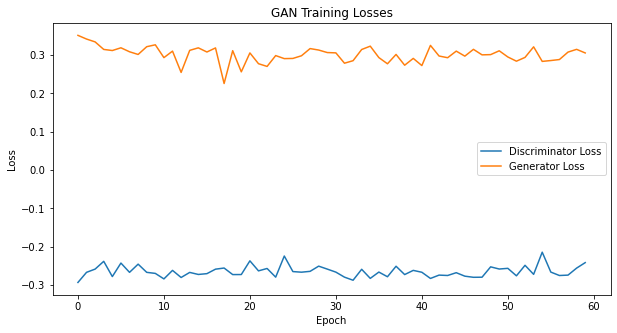

In [11]:
best_gan_estimator = GANEstimator(
    latent_dim=best_params['latent_dim'],
    image_channels=3,
    image_size=64,
    learning_rate=best_params['learning_rate'],
    data_root='/Users/isikgurhan/Desktop/data-jpg/alldata'
)

best_d_losses, best_g_losses = best_gan_estimator.fit(
    num_epochs=best_params['num_epochs'],
    batch_size=best_params['batch_size'],
    n_critic=5,
    clip_value=0.01,
    evaluation_interval=100
)

best_gan_estimator.save_model('best_gan_weights.pth')

# Plot losses
best_gan_estimator.plot_losses(best_d_losses, best_g_losses)